# Quantum Phase Estimation (QPE) for H₂ — **Noisy** (Pure Package Client)

- Uses the packaged QPE API (no manual QNodes / devices)
- Adds depolarizing / amplitude damping noise
- Compares to Hartree–Fock (HF)
- Sweeps noise strengths across multiple seeds

In [ ]:
import numpy as np

from qpe.core import run_qpe
from qpe.hamiltonian import build_hamiltonian
from qpe.io_utils import ensure_dirs
from qpe.visualize import plot_qpe_distribution, plot_qpe_sweep

ensure_dirs()

In [ ]:
molecule_name = "H2"
seed = 0

n_ancilla = 4
t_evol = 1.0
trotter_steps = 2
shots = 1000

noise_params = {"p_dep": 0.1, "p_amp": 0.0}

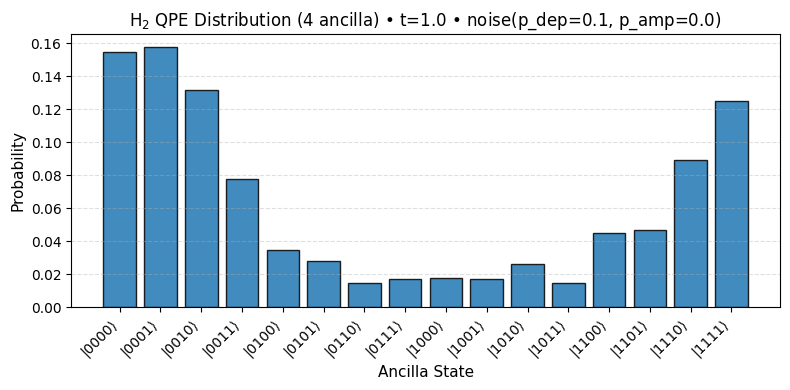

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/qpe/H2/distribution_dep10_4ancilla_t1.png
Most probable bitstring: 0001
Estimated phase: 0.062500
Estimated energy: -0.39269908 Ha
Hartree–Fock energy: -1.11668439 Ha
ΔE (QPE - HF): +0.72398531 Ha


In [ ]:
H, n_qubits, hf_state, symbols, coordinates, basis, charge, unit = build_hamiltonian(molecule_name)

common = dict(
    hamiltonian=H,
    hf_state=hf_state,
    t=float(t_evol),
    trotter_steps=int(trotter_steps),
    shots=int(shots) if shots is not None else None,
    system_qubits=int(n_qubits),
    molecule_name=molecule_name,
    force=False,  # use cache if present
)

result = run_qpe(
    n_ancilla=int(n_ancilla),
    seed=int(seed),
    noise_params=noise_params,
    **common,
)

plot_qpe_distribution(result, show=True, save=True)

print(f"Most probable bitstring: {result['best_bitstring']}")
print(f"Estimated phase: {result['phase']:.6f}")
print(f"Estimated energy: {result['energy']:.8f} Ha")
print(f"Hartree–Fock energy: {result['hf_energy']:.8f} Ha")
print(f"ΔE (QPE - HF): {result['energy'] - result['hf_energy']:+.8f} Ha")

## Sweep — Depolarizing probability (multi-seed)

For each noise level we run QPE across multiple random seeds and aggregate:
- Mean ± std of the estimated energy
- Mean ± std of the peak (most probable) bitstring probability

In [ ]:
p_dep_list = np.linspace(0.0, 0.1, 11)
seeds = list(range(5))

means, stds = [], []
peaks_mean, peaks_std = [], []

for p in p_dep_list:
    Es, Ps = [], []

    for sd in seeds:
        nparams = {"p_dep": float(p), "p_amp": 0.0}

        r = run_qpe(
            n_ancilla=int(n_ancilla),
            seed=int(sd),
            noise_params=nparams,
            **common,
        )

        Es.append(float(r["energy"]))
        Ps.append(float(r["probs"][r["best_bitstring"]]))

    Es = np.asarray(Es, dtype=float)
    Ps = np.asarray(Ps, dtype=float)

    means.append(float(Es.mean()))
    stds.append(float(Es.std(ddof=1)) if len(Es) > 1 else 0.0)

    peaks_mean.append(float(Ps.mean()))
    peaks_std.append(float(Ps.std(ddof=1)) if len(Ps) > 1 else 0.0)

💾 Saved QPE result → /workspaces/Variational_Quantum_Eigensolver/results/qpe/H2_4ancilla_t1_s0_dep09_682ee6ceaa58.json


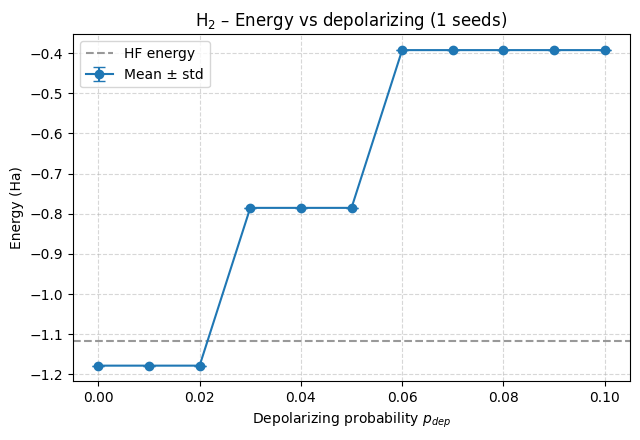

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/qpe/H2/sweep_4ancilla_energy_vs_depolarizing_1_seeds.png


In [ ]:
plot_qpe_sweep(
    p_dep_list,
    means,
    stds,
    seed=int(seed),
    molecule=molecule_name,
    sweep_label="Depolarizing probability $p_{dep}$",
    ylabel="Energy (Ha)",
    title=f"Energy vs depolarizing ({len(seeds)} seeds)",
    ref_value=result["hf_energy"],
    ref_label="HF energy",
    ancilla=int(n_ancilla),
    noise_params={"p_dep": 0.0, "p_amp": 0.0},
    show=True,
    save=True,
)

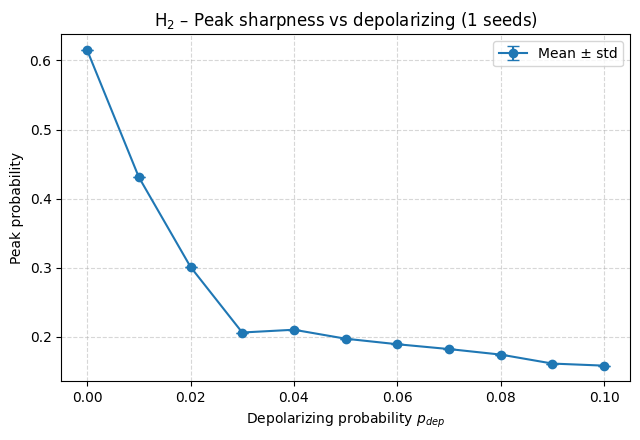

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/qpe/H2/sweep_4ancilla_peak_sharpness_vs_depolarizing_1_seeds.png


In [ ]:
plot_qpe_sweep(
    p_dep_list,
    peaks_mean,
    peaks_std,
    seed=int(seed),
    molecule=molecule_name,
    sweep_label="Depolarizing probability $p_{dep}$",
    ylabel="Peak probability",
    title=f"Peak sharpness vs depolarizing ({len(seeds)} seeds)",
    ref_value=None,
    ancilla=int(n_ancilla),
    noise_params={"p_dep": 0.0, "p_amp": 0.0},
    show=True,
    save=True,
)